In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq

In [2]:
def solve_advection_equation(method):
    # Define the grid parameters
    dx = 25e3   # Spatial step size
    dt = 1000  # Temporal step size
    L = 1500e3   # Domain length
    T = 160*3600     # Simulation time
    c0 = 10    # Constant value for initial condition

    # Define the velocity and initial condition
    u = 10 #m/s

    def initial_condition(x):
        if x < 1125e3 or x > 1375e3:
            return 0
        else:
            return c0

    # Create the grid
    x = np.arange(0, L, dx)
    t = np.arange(0, T, dt)

    # Initialize the solution matrix
    C = np.zeros((len(t), len(x)))

    # Set the initial condition
    for j in range(len(x)):
        C[0,j] = initial_condition(x[j])

    # Compute the solution using the specified difference integration method
    if method == 'Euler':
        for i in range(len(t)-1):
            for j in range(1, len(x)):
                C[i+1,j] = C[i,j] - (u*dt/dx)*(C[i,j]-C[i,j-1])
                # Apply periodic boundary conditions
            C[i+1,0] = C[i+1,-2]
            C[i+1,-1] = C[i+1,1]
    elif method == 'Lax-Wendroff':
        u0 = 10 #m/s
        for i in range(len(t)-1):
            for j in range(1, len(x)-2):
                C[i+1,j] = C[i,j]-(u0*dt/(2*dx)) * ((C[i,j+1]-C[i,j-1])) + 0.5*(np.square(u0)*np.square(dt)/np.square(dx))*(C[i,j+1]-2*C[i,j]+C[i,j-1]) 
            # Apply periodic boundary conditions
            C[i+1,0] = C[i+1,-3]
            C[i+1,-2] = C[i+1,1]
    
    return C


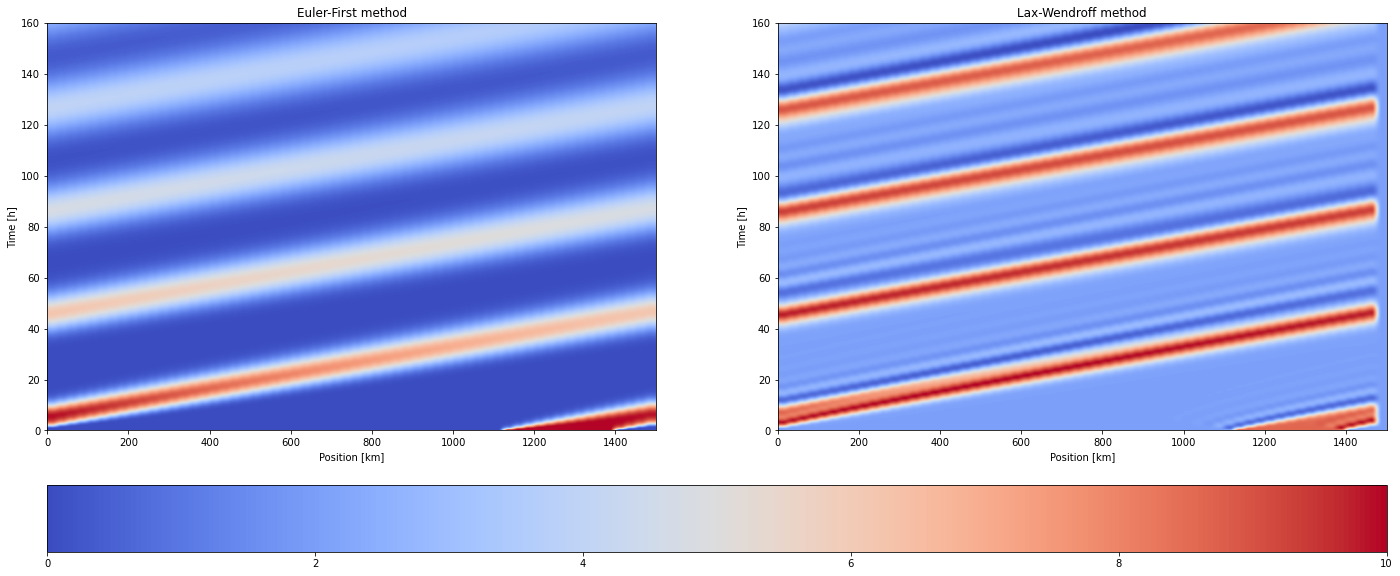

In [27]:
# Plot the solution
fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)

# First subplot
im1 = axs[0].imshow(solve_advection_equation('Euler'), aspect='auto', cmap='coolwarm', origin='lower', extent=[0, 1500e3/1e3, 0, 160*3600/3600])
axs[0].set_xlabel('Position [km]')
axs[0].set_ylabel('Time [h]')
axs[0].set_title('Euler-First method')

# Second subplot
im2 = axs[1].imshow(solve_advection_equation('Lax-Wendroff'), aspect='auto', cmap='coolwarm', origin='lower', extent=[0, 1500e3/1e3, 0, 160*3600/3600])
axs[1].set_xlabel('Position [km]')
axs[1].set_ylabel('Time [h]')
axs[1].set_title('Lax-Wendroff method')

# Add a colorbar for both subplots
cbar = fig.colorbar(im1, ax=axs, location='bottom', pad=0.1)

# fig.tight_layout()
plt.show()


# Difusie!! belangrijk
Bij Lax-Wendroff methode

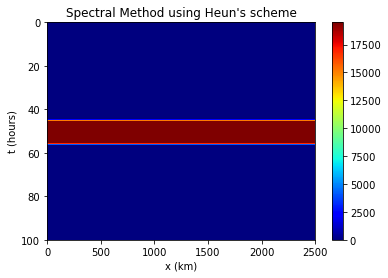

In [50]:


# Define the grid parameters
dx = 25e3    # Spatial step size
dt = 2000    # Temporal step size
L = 2500e3   # Domain length
T = 100*3600 # Simulation time

# Define the velocity and initial condition
u = 10 # m/s
c0 = 10

def initial_condition(x):
        if x < 1125e3 or x > 1375e3:
            return 0
        else:
            return c0

# Create the grid
x = np.arange(0, L, dx)
t = np.arange(0, T, dt)

# Compute the wavenumber
k = fftfreq(len(x), dx)

# Initialize the solution matrix
C = np.zeros((len(t), len(x)))

for j in range(len(x)):
    C[0,j] = initial_condition(x[j])
    
    
# Define the spectral operator
L_op = -(u/L)*2j*np.pi*k

# Compute the solution using the Heun's scheme
for i in range(len(t)-1):
    # First step of Heun's scheme
    C_hat = fft(C[i,:])
    C_tilde = C_hat + dt*L_op*C_hat
    C_tilde = np.real(ifft(C_tilde))
    # Second step of Heun's scheme
    C_hat_tilde = fft(C_tilde)
    C[i+1,:] = np.real(ifft(0.5*(C_hat + C_hat_tilde + dt*L_op*C_hat_tilde)))
    for j in range(len(x))
    # Apply periodic boundary conditions
#     C[i+1,0] = C[i+1,-2]
#     C[i+1,-1] = C[i+1,1]
    
    
C_physical = np.real(ifft(C, axis=1))

C_sol = np.zeros((len(x), len(t)))

for idx, val in enumerate(C):
    pred_c = -dt*2j*np.pi*u*val/L + val
    C_sol[:,idx] = np.real((-dt*2j*np.pi*u*val/L * pred_c + val)*dt)


# Plot the solution
plt.imshow(C_sol, cmap='jet', aspect='auto', extent=[0, L/1e3, T/3600, 0])
plt.colorbar()
plt.xlabel('x (km)')
plt.ylabel('t (hours)')
plt.title('Spectral Method using Heun\'s scheme')
plt.show()


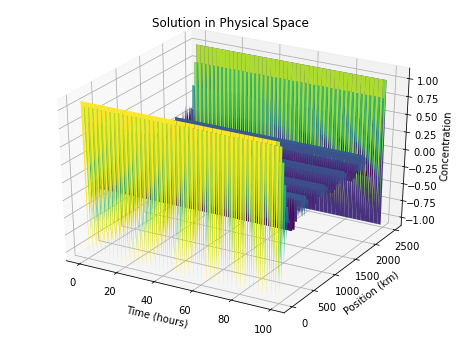

In [44]:
%matplotlib inline

T, X = np.meshgrid(t, x)


# Plot the 3D surface plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T/3600, X/1e3, C_physical.T, cmap='viridis')
# ax.plot_surface(T/3600, X/1e3, C.T, cmap='viridis')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Position (km)')
ax.set_zlabel('Concentration')
ax.set_title('Solution in Physical Space')
plt.show()